# Fisher Matrix Validation: Monte Carlo Analysis

This notebook validates the Fisher matrix approximation by comparing Monte Carlo parameter estimates with the theoretical Gaussian distribution predicted by the Fisher matrix.

**Theoretical expectation:** The Maximum Likelihood Estimators (MLEs) from noise realizations should follow a multivariate Gaussian distribution:

$$\hat{\theta} \sim \mathcal{N}(\theta_{\text{true}}, \Gamma^{-1})$$

where $\Gamma^{-1}$ is the inverse Fisher matrix (parameter covariance matrix).

In [17]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
import corner
from scipy import stats
import sys
import os

# Add path to utility functions
sys.path.append("../../..")
from utility_funcs.hdf5_file_management import load_fisher_results_from_hdf5

# Set plotting parameters
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# File configuration
base_dir = "/work/scratch/data/burkeol/Gaps_EMRIs/Fisher_Matrices"
print("Available Fisher Matrix simulations are", os.listdir(base_dir))

Available Fisher Matrix simulations are ['Fisher_Matrix_Case_1_w_mask.h5', 'Fisher_Matrix_Case_1_w_window.h5', 'Fisher_Matrix_Case_1_no_window.h5', 'Fisher_Matrix_Case_1_w_mask_PAAM_and_antenna.h5']


## 1. Load Fisher Matrix and Monte Carlo Results

In [18]:

filename = 'Fisher_Matrix_Case_1_no_window.h5'  # Adjust filename as needed
file_path = Path(base_dir) / filename

# Load data
print(f"Loading data from: {file_path}")
data = load_fisher_results_from_hdf5(str(file_path))

# Extract key components
param_names = data['parameter_names']
fisher_covariance = data['inverse_fisher_matrix']  # Inverse Fisher matrix
emri_params = data['emri_parameters']

# Extract Monte Carlo results
mc_data = data['monte_carlo_analysis']
mle_realizations = mc_data['noise_MLE_realizations']  # Shape: (n_realizations, n_params)
empirical_covariance = mc_data['empirical_covariance_matrix']
n_realizations = mc_data['n_realizations']

print(f"\nLoaded {n_realizations} Monte Carlo realizations")
print(f"Parameters: {param_names}")
print(f"MLE realizations shape: {mle_realizations.shape}")
print(f"Fisher covariance shape: {fisher_covariance.shape}")

Loading data from: /work/scratch/data/burkeol/Gaps_EMRIs/Fisher_Matrices/Fisher_Matrix_Case_1_no_window.h5
Loaded Fisher matrix data as NumPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (1000 realizations)

Loaded 1000 Monte Carlo realizations
Parameters: ['m1', 'm2', 'a', 'p0', 'e0', 'dist', 'qS', 'phiS', 'qK', 'phiK', 'Phi_phi0', 'Phi_r0']
MLE realizations shape: (1000, 12)
Fisher covariance shape: (12, 12)


## 2. Extract True Parameter Values and Center the Data

In [19]:
# Extract true parameter values in the same order as param_names
true_params = np.array([emri_params[name] for name in param_names])

# Center the MLE realizations around the true values
centered_mles = mle_realizations - true_params[None, :]

# Calculate statistics
empirical_means = np.mean(centered_mles, axis=0)
fisher_uncertainties = np.sqrt(np.diag(fisher_covariance))
empirical_uncertainties = np.sqrt(np.diag(empirical_covariance))

print("\nParameter comparison (Fisher vs Empirical uncertainties):")
print(f"{'Parameter':<12} {'True Value':<15} {'Fisher σ':<12} {'MC σ':<12} {'Ratio':<8}")
print("-" * 65)
for i, name in enumerate(param_names):
    ratio = fisher_uncertainties[i] / empirical_uncertainties[i]
    print(f"{name:<12} {true_params[i]:<15.6e} {fisher_uncertainties[i]:<12.6e} "
          f"{empirical_uncertainties[i]:<12.6e} {ratio:<8.3f}")


Parameter comparison (Fisher vs Empirical uncertainties):
Parameter    True Value      Fisher σ     MC σ         Ratio   
-----------------------------------------------------------------
m1           1.000000e+06    1.289995e+00 1.277191e+00 1.010   
m2           1.000000e+01    1.716160e-05 1.728676e-05 0.993   
a            9.980000e-01    4.659040e-07 4.625821e-07 1.007   
p0           7.737500e+00    3.834321e-06 3.806839e-06 1.007   
e0           7.300000e-01    2.185750e-07 2.199899e-07 0.994   
dist         2.203608e+00    8.366418e-02 8.273063e-02 1.011   
qS           8.000000e-01    2.991570e-03 2.951911e-03 1.013   
phiS         2.200000e+00    3.149589e-03 3.190114e-03 0.987   
qK           1.600000e+00    2.322718e-02 2.296259e-02 1.012   
phiK         1.200000e+00    2.260202e-02 2.266893e-02 0.997   
Phi_phi0     2.000000e+00    6.807855e-02 6.973084e-02 0.976   
Phi_r0       3.000000e+00    1.574559e-02 1.597765e-02 0.985   


## 3. Individual Parameter Histogram Validation

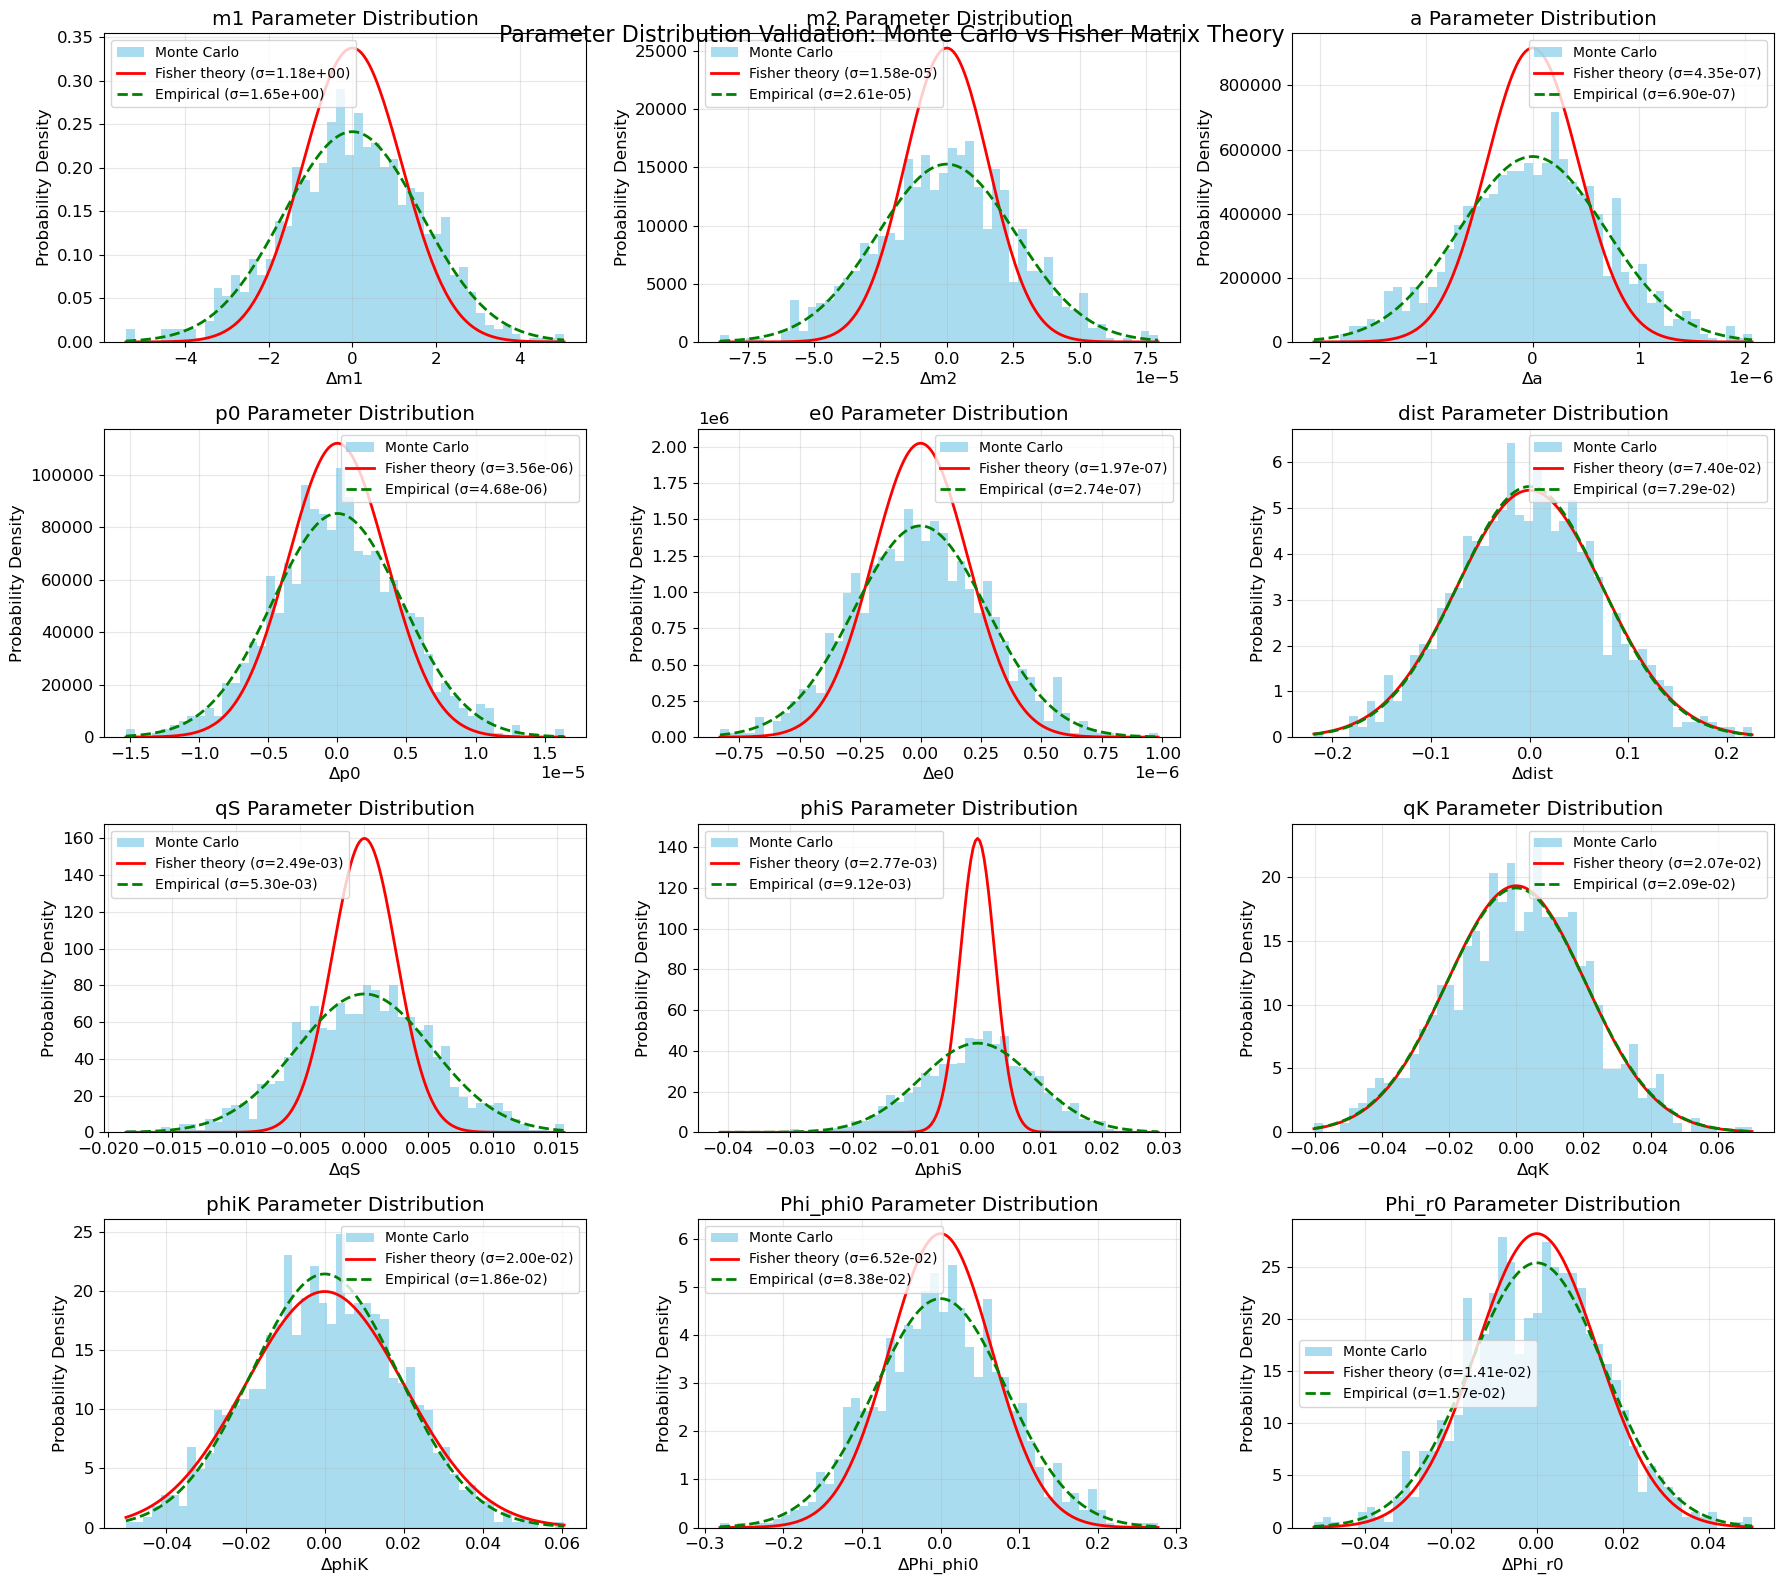

In [34]:
# Create subplots for all parameters
n_params = len(param_names)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()

for i, (name, ax) in enumerate(zip(param_names, axes)):
    # Extract parameter data
    param_data = centered_mles[:, i]
    fisher_sigma = fisher_uncertainties[i]
    empirical_sigma = empirical_uncertainties[i]
    
    # Create histogram
    counts, bins, _ = ax.hist(param_data, bins=50, density=True, alpha=0.7, 
                             color='skyblue', label='Monte Carlo')
    
    # Overlay theoretical Gaussian from Fisher matrix
    x_range = np.linspace(param_data.min(), param_data.max(), 200)
    fisher_gaussian = stats.norm.pdf(x_range, 0, fisher_sigma)
    ax.plot(x_range, fisher_gaussian, 'r-', linewidth=2, 
            label=f'Fisher theory (σ={fisher_sigma:.2e})')
    
    # Overlay empirical Gaussian
    empirical_gaussian = stats.norm.pdf(x_range, 0, empirical_sigma)
    ax.plot(x_range, empirical_gaussian, 'g--', linewidth=2, 
            label=f'Empirical (σ={empirical_sigma:.2e})')
    
    # Formatting
    ax.set_xlabel(f'Δ{name}')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{name} Parameter Distribution')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Parameter Distribution Validation: Monte Carlo vs Fisher Matrix Theory', 
             fontsize=16, y=0.98)
plt.show()

## 4. Covariance Matrix Comparison

/work/scratch/env/burkeol/.conda/envs/few_1PA_trex/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()
/work/scratch/env/burkeol/.conda/envs/few_1PA_trex/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/work/scratch/env/burkeol/.conda/envs/few_1PA_trex/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


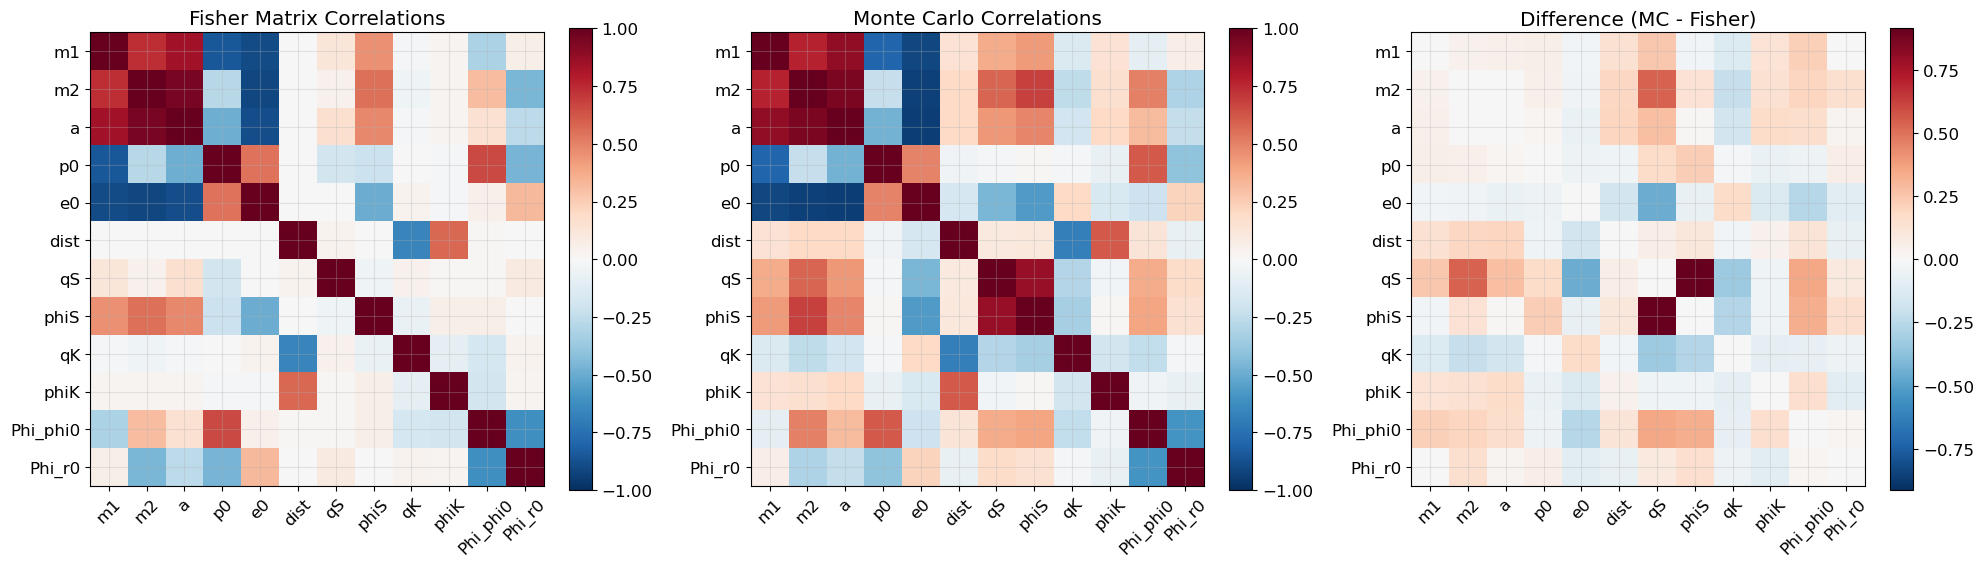


Maximum correlation difference: 0.9136
RMS correlation difference: 0.1924


In [35]:
# Calculate correlation matrices
fisher_corr = fisher_covariance / np.sqrt(np.outer(np.diag(fisher_covariance), 
                                                   np.diag(fisher_covariance)))
empirical_corr = empirical_covariance / np.sqrt(np.outer(np.diag(empirical_covariance), 
                                                        np.diag(empirical_covariance)))

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Fisher correlation matrix
im1 = axes[0].imshow(fisher_corr, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_title('Fisher Matrix Correlations')
axes[0].set_xticks(range(n_params))
axes[0].set_yticks(range(n_params))
axes[0].set_xticklabels(param_names, rotation=45)
axes[0].set_yticklabels(param_names)
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Empirical correlation matrix
im2 = axes[1].imshow(empirical_corr, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_title('Monte Carlo Correlations')
axes[1].set_xticks(range(n_params))
axes[1].set_yticks(range(n_params))
axes[1].set_xticklabels(param_names, rotation=45)
axes[1].set_yticklabels(param_names)
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# Difference
diff = empirical_corr - fisher_corr
max_diff = np.max(np.abs(diff))
im3 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
axes[2].set_title('Difference (MC - Fisher)')
axes[2].set_xticks(range(n_params))
axes[2].set_yticks(range(n_params))
axes[2].set_xticklabels(param_names, rotation=45)
axes[2].set_yticklabels(param_names)
plt.colorbar(im3, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

print(f"\nMaximum correlation difference: {max_diff:.4f}")
print(f"RMS correlation difference: {np.sqrt(np.mean(diff**2)):.4f}")

## 5. Corner Plot Comparison

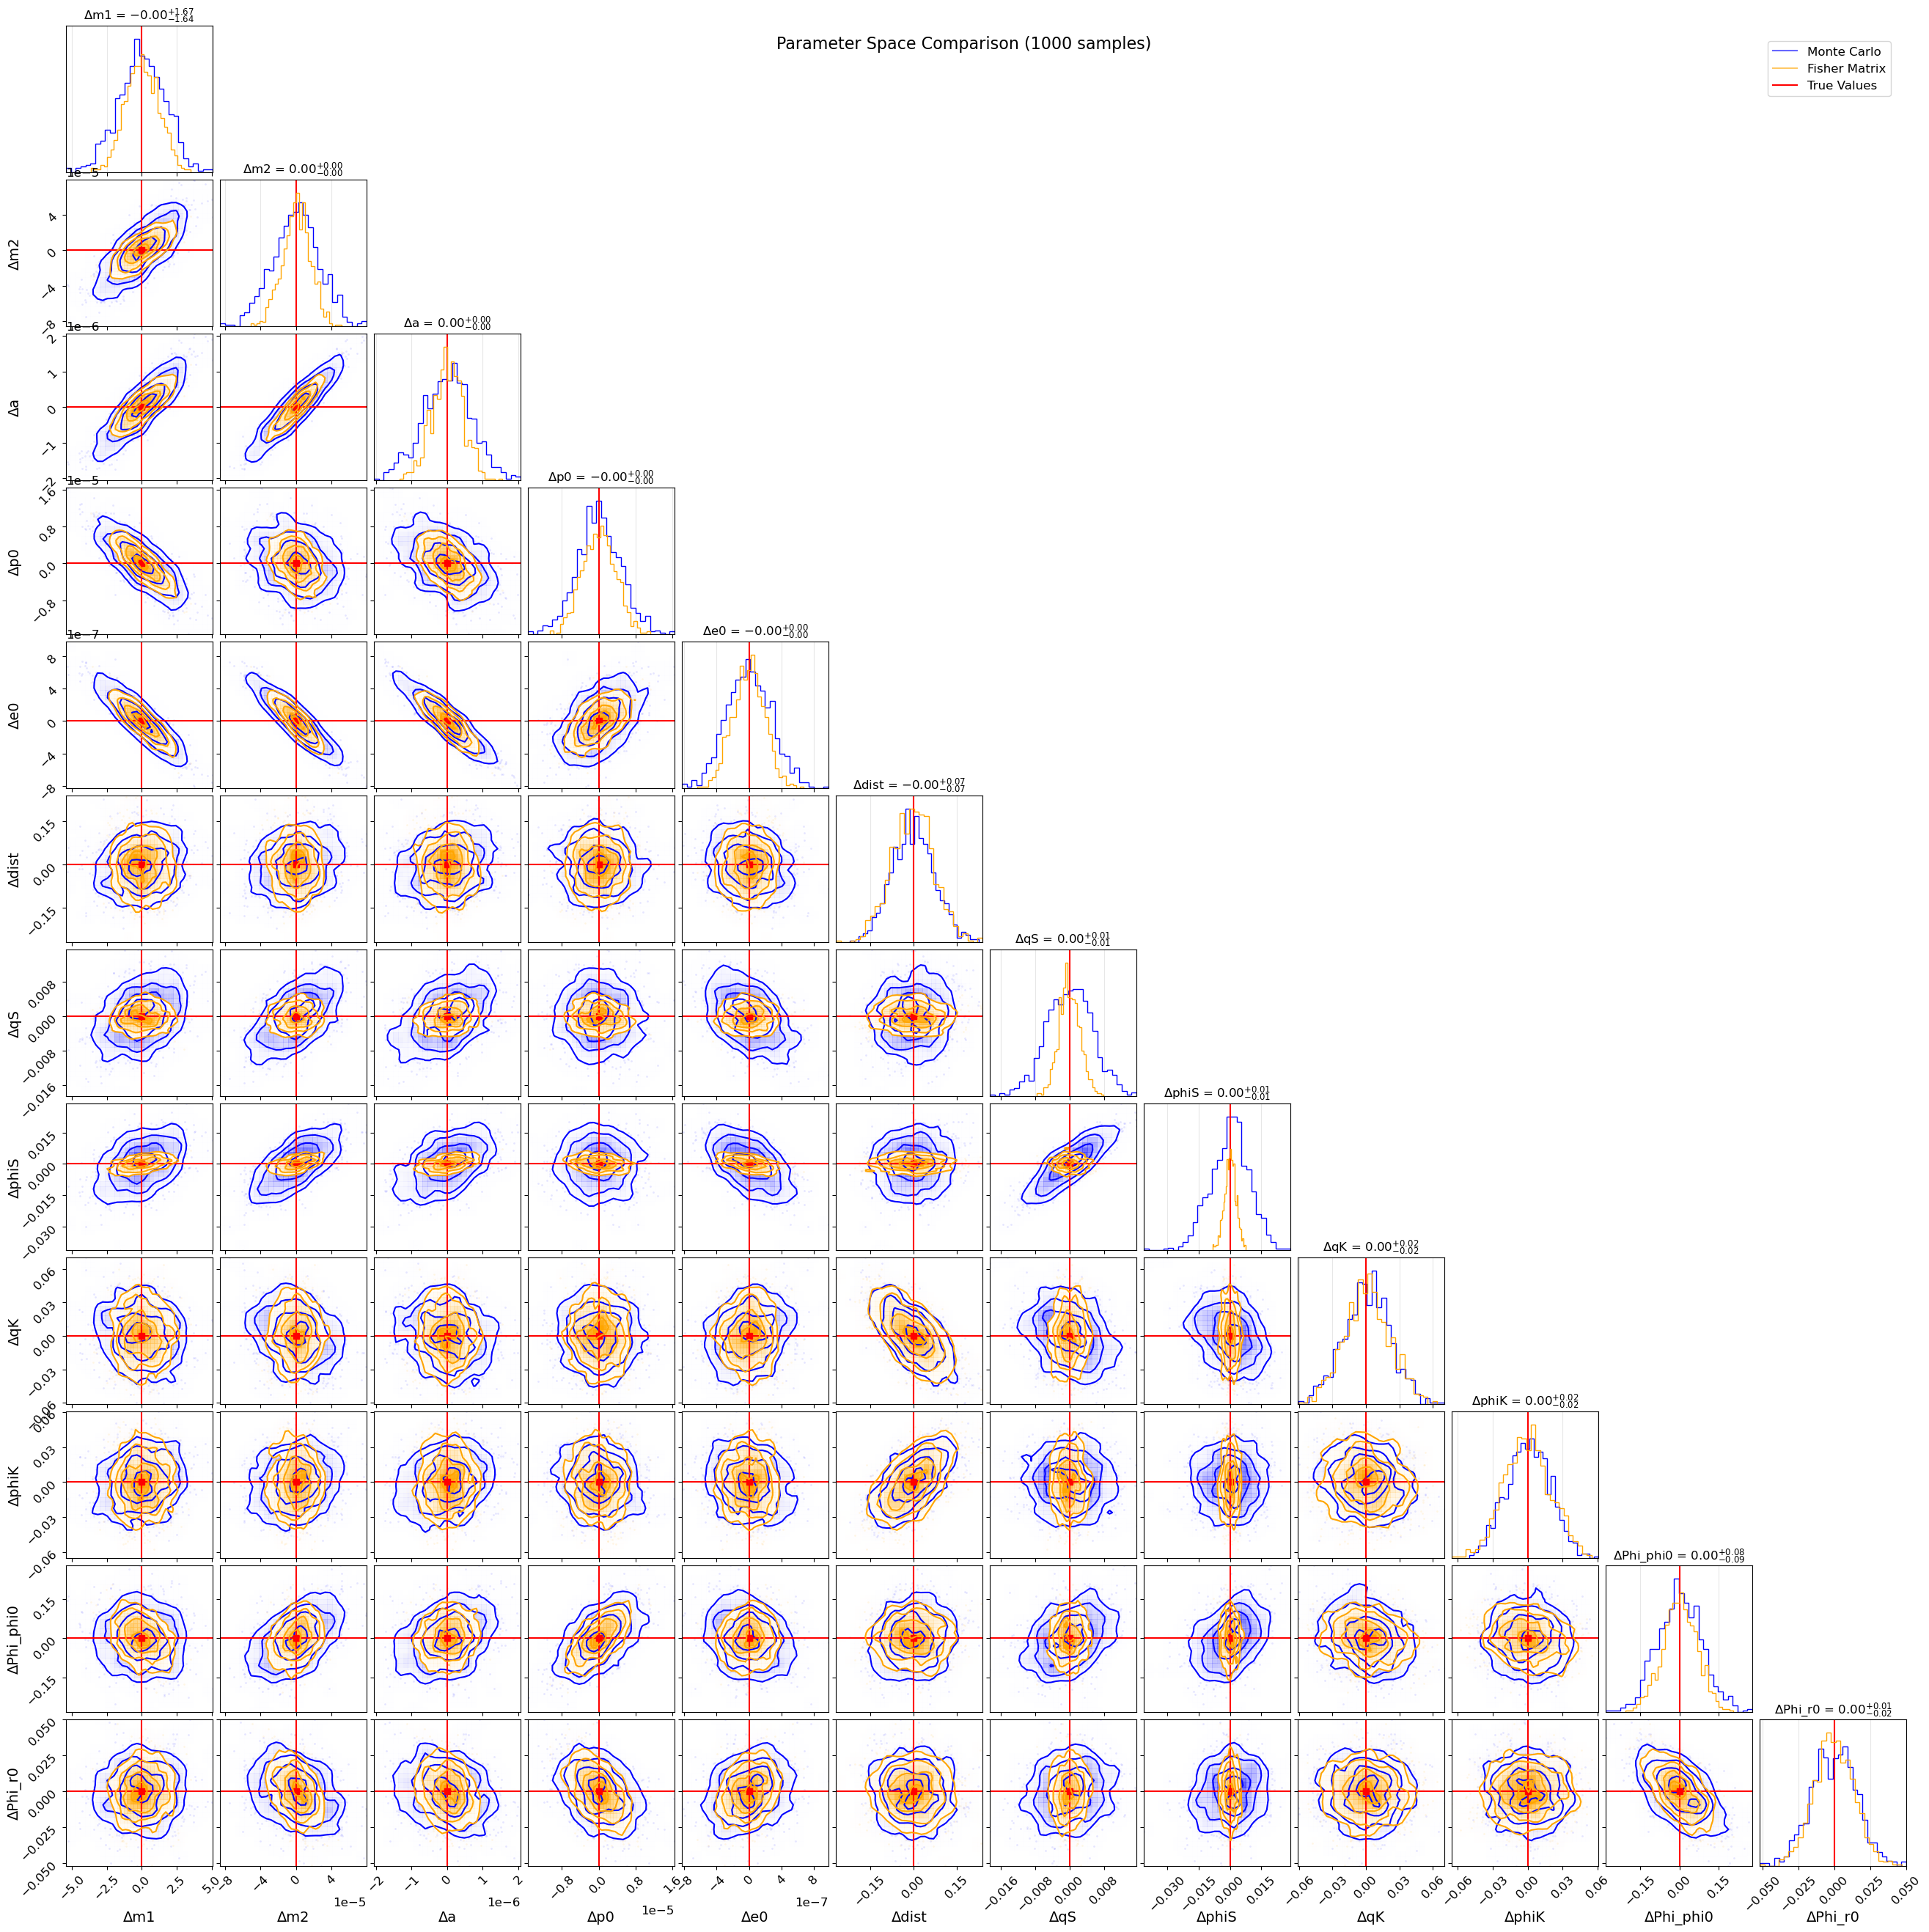

In [36]:
# Create corner plot comparing Monte Carlo samples with Fisher matrix prediction
# Note: corner plots work better with a subset of data for visualization
n_plot_samples = min(5000, n_realizations)  # Use subset for cleaner plotting
plot_indices = np.random.choice(n_realizations, n_plot_samples, replace=False)

# Monte Carlo corner plot
fig = corner.corner(centered_mles[plot_indices], 
                   labels=[f'Δ{name}' for name in param_names],
                   truths=np.zeros(n_params),  # True values are zero (centered data)
                   truth_color='red',
                   color='blue',
                   alpha=0.6,
                   bins=30,
                   smooth=1.0,
                   show_titles=True,
                   title_kwargs={"fontsize": 12},
                   label_kwargs={"fontsize": 14})

# Overlay Fisher matrix prediction
# Generate samples from Fisher matrix covariance
fisher_samples = np.random.multivariate_normal(np.zeros(n_params), 
                                               fisher_covariance, 
                                               size=n_plot_samples)

# Overlay on existing corner plot
corner.corner(fisher_samples, 
             fig=fig,
             color='orange',
             alpha=0.3,
             bins=30,
             smooth=1.0)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', alpha=0.6, label='Monte Carlo'),
                  Line2D([0], [0], color='orange', alpha=0.6, label='Fisher Matrix'),
                  Line2D([0], [0], color='red', label='True Values')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.suptitle(f'Parameter Space Comparison ({n_plot_samples} samples)', 
             fontsize=16, y=0.98)
plt.show()

## 6. Quantitative Assessment Summary

In [37]:
# Calculate overall agreement metrics
uncertainty_ratios = fisher_uncertainties / empirical_uncertainties
mean_ratio = np.mean(uncertainty_ratios)
std_ratio = np.std(uncertainty_ratios)

# Covariance matrix agreement
cov_relative_error = np.abs(fisher_covariance - empirical_covariance) / np.abs(empirical_covariance)
mean_cov_error = np.mean(cov_relative_error)

print("\n" + "="*60)
print("FISHER MATRIX VALIDATION SUMMARY")
print("="*60)

print(f"\nNumber of Monte Carlo realizations: {n_realizations:,}")
print(f"Number of parameters: {n_params}")

print(f"\nUNCERTAINTY COMPARISON:")
print(f"  Mean Fisher/MC uncertainty ratio: {mean_ratio:.3f} ± {std_ratio:.3f}")
print(f"  Ratio range: {uncertainty_ratios.min():.3f} - {uncertainty_ratios.max():.3f}")

print(f"\nCOVARIANCE MATRIX AGREEMENT:")
print(f"  Mean relative error: {mean_cov_error:.3f}")
print(f"  Max correlation difference: {max_diff:.4f}")
print(f"  RMS correlation difference: {np.sqrt(np.mean(diff**2)):.4f}")

print(f"\nVALIDATION STATUS:")
if 0.9 <= mean_ratio <= 1.1 and max_diff < 0.1:
    print("  ✓ PASSED: Fisher matrix provides accurate uncertainty estimates")
elif 0.8 <= mean_ratio <= 1.2 and max_diff < 0.2:
    print("  ~ MARGINAL: Fisher matrix provides reasonable uncertainty estimates")
else:
    print("  ✗ FAILED: Significant discrepancy between Fisher and Monte Carlo")

print(f"\nParameters with largest discrepancies:")
sorted_indices = np.argsort(np.abs(uncertainty_ratios - 1))[::-1]
for i in sorted_indices[:3]:
    print(f"  {param_names[i]}: ratio = {uncertainty_ratios[i]:.3f}")

print("\n" + "="*60)


FISHER MATRIX VALIDATION SUMMARY

Number of Monte Carlo realizations: 1,000
Number of parameters: 12

UNCERTAINTY COMPARISON:
  Mean Fisher/MC uncertainty ratio: 0.747 ± 0.218
  Ratio range: 0.303 - 1.074

COVARIANCE MATRIX AGREEMENT:
  Mean relative error: 0.917
  Max correlation difference: 0.9136
  RMS correlation difference: 0.1924

VALIDATION STATUS:
  ✗ FAILED: Significant discrepancy between Fisher and Monte Carlo

Parameters with largest discrepancies:
  phiS: ratio = 0.303
  qS: ratio = 0.471
  m2: ratio = 0.605

